# Neal's funnel example

## Conclusion

This workbook shows that appropriately tayloring the kinetic energy distribution does not seem to help with efficient sampling of the funnel, which is to be expected as the challenge of moving from the neck to the top requires more than just stabilising numerical solvers.

## The model

We consider the model

\begin{align}
\nu &\sim N(0,3^2), \\
x_i|\nu &\sim N(0,e^\nu), ~~ i = 1,...,9.
\end{align}

This gives rise to the potential

\begin{equation}
U(x,\nu) = \frac{1}{18}\nu^2 + \frac{9}{2}\nu + \frac{e^{-\nu}}{2}\sum_{i=1}^9 x_i^2,
\end{equation}

which has associated gradients

\begin{equation}
\frac{\partial U}{\partial x_i} = 2x_i e^{-\nu}, ~~ \frac{\partial U}{\partial \nu} = \frac{\nu}{9} + \frac{9}{2} - \frac{e^{-\nu}}{2} \sum_{i=1}^9 x_i^2.
\end{equation}


In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# specific functions
import HMC as h
from k_energies import *
import MC_diag as diag

# Create potential class
class NealFunnel:
    def value(self, x):
        return x[0]**2/18.0 + 9*x[0]/2.0 + exp(-x[0])*np.sum(x[1:10]**2)/2.0
    
    def grad(self, x):
        g = np.empty(len(x))
        g[0] = x[0]/9.0 + 9/2.0 - exp(-x[0])*np.sum(x[1:10]**2)/2.0
        g[1:10] = 2.0*x[1:10]*exp(-x[0])
        return g        
    
x = -10*np.ones(10)
U = NealFunnel()
print U.value(x)
print U.grad(x)

9911870.16322
[-9911906.21877413  -440529.31589613  -440529.31589613  -440529.31589613
  -440529.31589613  -440529.31589613  -440529.31589613  -440529.31589613
  -440529.31589613  -440529.31589613]


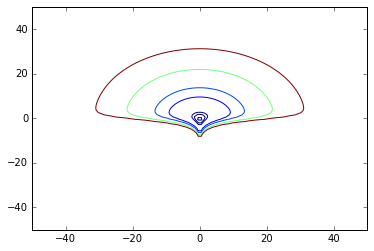

In [2]:
# Simple checks

# Create contour plot and add trajectories with various choices of KE, PE(4/3) should stabilise flow.
xlist = np.linspace(-50.0, 50.0, 100)
ylist = np.linspace(-50.0, 50.0, 100) # Create 1-D arrays for x,y dimensions
X,Y = np.meshgrid(xlist, ylist) # Create 2-D grid xlist,ylist values

Z = X**2 + Y**2 + Y + X**2 * np.exp(-Y)
plt.contour(X, Y, Z, [1,5,10,100, 200, 500, 1000]);

In [3]:
# sampling from the funnel
U = NealFunnel()

K_g = Gauss()
K_r = Laplace()
# ideally we want a p(1 - ln(p) kinetic energy, which we could sample from using adaptive rejection sampling.

n_samples = 50000
x_start = np.zeros(10)

neg_r = h.HMC(n_samples, x_start, U, K_r, L = 10, e = 0.01, BurnIn = 1000)
neg_g = h.HMC(n_samples, x_start, U, K_g, L = 10, e = 0.01, BurnIn = 1000)

samples_r = neg_r['x']
samples_g = neg_g['x']

Acceptance rate: 0.639735
LF Steps: 10, Step-size: 0.026
Numerical divergences: 0
Acceptance rate: 0.789796
LF Steps: 10, Step-size: 0.018
Numerical divergences: 0


[1] 55.58087

[1] 8.573536



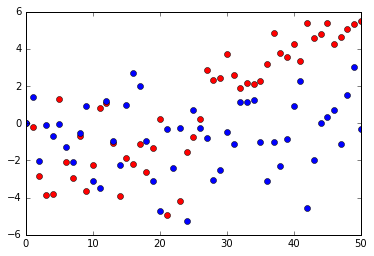

In [4]:
#plt.plot(samples_r[0,:], 'b-');
#plt.plot(samples_g[0,:], 'r-');

print diag.ess(samples_r[0,:])
print diag.ess(samples_g[0,:])

def thin(x, level):
    n = len(x)
    index = np.asarray(range(n))
    index_to_keep = np.nonzero( index/level==index/float(level) )
    return x[index_to_keep]

gauss_thinned = thin(samples_g[0,:], level = 1000)
relative_thinned = thin(samples_r[0,:], level = 1000)

#print gauss_thinned

axes = plt.gca()
axes.set_ylim([-6,6])

plt.plot(gauss_thinned, 'ro')
plt.plot(relative_thinned, 'bo');

0.0309793804124
0.0159796804064


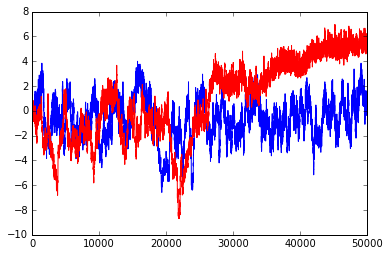

In [6]:
plt.plot(samples_r[0,:], 'b-')
plt.plot(samples_g[0,:], 'r-');

print np.sum(samples_g[0,:] < -5)/float(len(samples_g[0,:]))
print np.sum(samples_r[0,:] < -5)/float(len(samples_r[0,:]))

Neither of the above runs exhibit very stable behaviour.  It's clear that both samlers struggle to move between the areaa below and above 4, which correspond to the neck and top of the funnel.